<a href="https://colab.research.google.com/github/sara87821/20210602/blob/main/00_siamese_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from keras.utils import plot_model


num_classes = 10
epochs = 20


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            # Positive
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            # Negative
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


In [ ]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)
tr_y = tr_y.astype('float32')
te_y = te_y.astype('float32')

In [ ]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [ ]:
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
functional_13 (Functional)      (None, 128)          133504      input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1)            0           functional_13[0][0]  

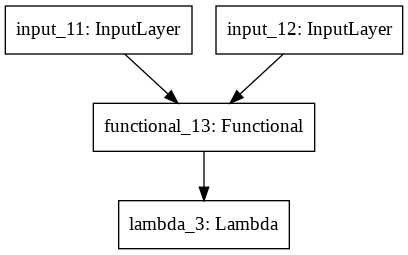

In [ ]:
plot_model(model)

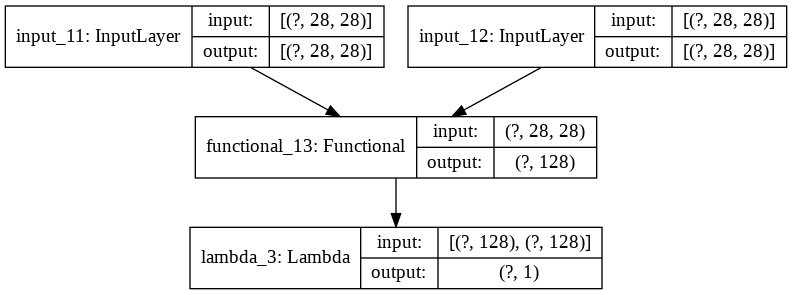

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
# train
model.compile(loss=contrastive_loss, optimizer='adam', metrics=['accuracy'])

model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Epoch 1/20
847/847 [==============================] - 3s 4ms/step - loss: 0.1085 - accuracy: 0.1357 - val_loss: 0.0491 - val_accuracy: 0.0538
Epoch 2/20
847/847 [==============================] - 3s 4ms/step - loss: 0.0483 - accuracy: 0.0482 - val_loss: 0.0358 - val_accuracy: 0.0355
Epoch 3/20
847/847 [==============================] - 3s 4ms/step - loss: 0.0338 - accuracy: 0.0326 - val_loss: 0.0295 - val_accuracy: 0.0315
Epoch 4/20
847/847 [==============================] - 3s 4ms/step - loss: 0.0265 - accuracy: 0.0260 - val_loss: 0.0276 - val_accuracy: 0.0320
Epoch 5/20
847/847 [==============================] - 3s 3ms/step - loss: 0.0226 - accuracy: 0.0229 - val_loss: 0.0245 - val_accuracy: 0.0267
Epoch 6/20
847/847 [==============================] - 3s 4ms/step - loss: 0.0195 - accuracy: 0.0192 - val_loss: 0.0252 - val_accuracy: 0.0296
Epoch 7/20
847/847 [==============================] - 3s 4ms/step - loss: 0.0173 - accuracy: 0.0177 - val_loss: 0.0241 - val_accuracy: 0.0267
Epoch 

In [ ]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.67%
* Accuracy on test set: 97.37%


17620

idx: 4236
Same ?:  1.0


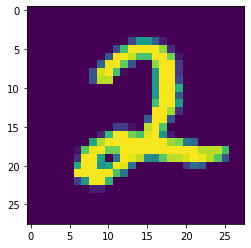

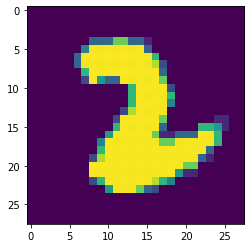

In [ ]:
idx = np.random.randint(0, te_pairs.shape[0])
print('idx:', idx)
print('Same ?: ', te_y[idx])
plt.imshow(te_pairs[idx, 0])
plt.show()
plt.imshow(te_pairs[idx, 1])
plt.show()

In [ ]:
model.predict([te_pairs[idx:idx+1, 0], te_pairs[idx:idx+1, 1]])

array([[0.02711091]], dtype=float32)